In [1]:
import os, glob
import numpy as np
import pandas as pd
from scipy import stats
from datetime import date, time, datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import np_utils
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,  accuracy_score

w_list= glob.glob("../result/merge_weather/*.csv")
p_list = glob.glob("../result/flower_price_byweek/*")
select_t = [(1,0),(3,2),(2,1),(2,3),(2,4)]
st, flower = select_t[0]
fn_weather = w_list[st]
fn_price = p_list[flower]

print(fn_weather, fn_price)

Using TensorFlow backend.


../result/merge_weather\C0F9L0_后里.csv ../result/flower_price_byweek\Anthurium_pbyweek.csv


In [2]:
r_data = pd.read_csv(fn_weather, encoding="utf-8")
col_fix =  ['T.Max', 'T.Min', 'Precp','Temperature', 'RH', 'StnPres', 'WS', 'WSGust']   
# rm "/"
for col in col_fix:
    old = r_data[col]
    new = []
    for i in range(len(old)):
        try:
            new.append(float(old[i]))
            tmp = float(old[i])
        except ValueError:
            new.append(tmp)
    r_data[col] = new
d_tmp = r_data['T.Max'] - r_data['T.Min']
r_data["d_tmp"]= d_tmp

# extract_date
d_data = r_data["Date"]
drop_c =["Date",'T.Max', 'T.Min']
r_data = r_data.drop(columns=drop_c)

def to_zscore2(df):
    col_x = df.columns.to_list()
    mean = df.mean(axis=0)
    std = df.std(axis=0)
    for i in range(len(col_x)):
        df[col_x[i]]=(df[col_x[i]]-mean[i])/std[i]
    return  df , (mean, std)

r_data, recordz = to_zscore2(r_data)

# r_data

In [3]:
print(r_data.shape)
print(d_data.shape)

(1866, 7)
(1866,)


In [4]:
shift1=42
shift2=1

dfs =[]
arr_all =[]
if shift2==0:
    df_s = r_data.copy()
else:
    df_s = r_data.copy()
    df_s = df_s.shift(periods=shift2)
#     d_data = np.array(pd.DataFrame(d_data).shift(periods=shift2))
#     add shift base
arr_all = np.array(df_s)

for i in range(1,shift1):
    tp = np.array(df_s.shift(periods=i))
    arr_all = np.concatenate((arr_all, tp), axis=1)
df_all = pd.DataFrame(arr_all)
df_all["date"] = d_data
df_all = df_all.dropna()
df_all = df_all.reset_index()
df_all = df_all.drop(columns="index")

# r_data = df_all

# df_all.shape

In [5]:
# df_all

In [6]:
r_data = df_all

d_data = r_data["date"]

def trans_to_y_w(d_date):
    year = int(d_date.split("-")[0])
    d_day = date(year,int(d_date.split("-")[1]), int(d_date.split("-")[2]))- date(year, 1, 1)
    d_w = 1+ (d_day.days // 7)
    if d_w ==53:
        d_w = 52
    result =  str(year) + "_" + str(d_w)

    if d_day.days % 7 ==6:
        return result
    else:
        return np.nan
    
d_new = []
for i in range(len(d_data)):
    d_new.append(trans_to_y_w(d_data[i]))
r_data["y_w"] = d_new
df_all = df_all.dropna()
df_all = df_all.reset_index()
df_all = df_all.drop(columns="index")
# r_data
# d_data.shape

In [7]:
df_pbw = pd.read_csv(fn_price, encoding="utf-8")
# join x and y
df_join = df_pbw.join(r_data.set_index("y_w"), on="y_w")
df_join = df_join.dropna()
df_join = df_join.reset_index()
df_join = df_join.drop(columns="index")
# extract y info
y_date = df_join["date"]
y_yw = df_join["y_w"]
y_raw = np.array(df_join["price_diff"])
d_t_dummy = ["market"]
tmp_dum = pd.DataFrame()
for col in d_t_dummy:
    tmp_dum[col] = df_join[col]
    dummy = pd.get_dummies(tmp_dum[col])
    df_join = pd.concat([df_join, dummy], axis=1)
drop_c = ["market","year", "week","w_avg", "w_sale", "date", "y_w", "price_diff"]
# x finished
x = np.array(df_join.drop(columns=drop_c))
# x

In [8]:
# modify y
# y_raw = np.array(df_join["price_diff"])
print("y_price_diff describe:")
print(pd.DataFrame(y_raw, columns=["y_price_diff"]).describe())
print("======")
def y_to_class(v):
    t = 0
    y_class_range = [-0.1,0,0.1]
#     for q in range(1,12):
#         y_class_range.append(round((q*0.1-0.6),4))

    for i in range(len(y_class_range)):
        if (v >= y_class_range[i]):
            t = i+1
    return int(t)

y_class = []

for i in range(len(y_raw)):
    y_class.append(y_to_class(y_raw[i]))
print("freq:",np.bincount(y_class))

y = np.array(y_class)
input_d = x.shape[1]
print(x.shape,len(y))
# x y ready

y_price_diff describe:
       y_price_diff
count   7812.000000
mean       0.010361
std        0.154614
min       -0.410906
25%       -0.089432
50%       -0.004678
75%        0.093753
max        0.791508
freq: [1765 2228 1963 1856]
(7812, 299) 7812


In [9]:
# split data
# y_date
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
y_year = []
for i in range(len(y_yw)):
    y_year.append(int(y_yw[i].split("_")[0]))
y_year = np.array(y_year)
years, count = np.unique(np.array(y_year), return_counts=True)
print(years)
print(count)

train = y_year[:]<=2017
test = y_year[:]>2017

x_train, y_train = x[train,:], y[train]
x_test, y_test = x[test,:], y[test]


[2014 2015 2016 2017 2018]
[1426 1612 1581 1612 1581]


In [10]:
# out_class_count = len(np.bincount(y))
# shifts = 28
# xy_data = (x_train, y_train, x_test, y_test)
# def model_build(xy_data, input_d, shifts, epochs=60):
#     x_train, y_train, x_test, y_test = xy_data
    
#     model = Sequential()
#     layer_0 = Dense(units =input_d//4, input_dim = input_d,
#                     kernel_initializer = "random_normal", activation = "relu")
#     model.add(layer_0)
#     model.add(Dropout(0.25))
#     layer_1 = Dense(units =shifts,kernel_initializer = "random_normal", activation = "relu")
#     model.add(layer_1)
#     model.add(Dropout(0.25))
#     layer_out = Dense(units = out_class_count,kernel_initializer = "random_normal", 
#                       activation = "softmax")
#     model.add(layer_out)
#     #     model.summary()
#     model.compile(loss="categorical_crossentropy",optimizer = "adam", metrics = ['accuracy'])
#     train_history = model.fit(x = x_train, y = np_utils.to_categorical(y_train), 
#                               validation_split = 0.1, epochs =epochs, verbose = 2)
    
#     #     model_test
#     pre = model.predict_classes(x_test)
#     acc = round(accuracy_score(y_test, pre)*100,2)
    
#     return acc, model, train_history

# acc_cf = 0

# for epochs in range(5,80,5):
#     print("epochs:", epochs)
#     acc, model ,train_history= model_build(xy_data, input_d, shifts, epochs=60)
#     print(train_history)
#     print(acc)
#     if acc > acc_cf:
#         acc_cf = acc
#         bestmodel = model



Train on 4984 samples, validate on 1247 samples
Epoch 1/20
 - 2s - loss: 0.9779 - acc: 0.5897 - val_loss: 0.9154 - val_acc: 0.6207
Epoch 2/20
 - 1s - loss: 0.7358 - acc: 0.6934 - val_loss: 0.8967 - val_acc: 0.6247
Epoch 3/20
 - 1s - loss: 0.6360 - acc: 0.7307 - val_loss: 0.8496 - val_acc: 0.6568
Epoch 4/20
 - 1s - loss: 0.5364 - acc: 0.7757 - val_loss: 0.7681 - val_acc: 0.6881
Epoch 5/20
 - 1s - loss: 0.4581 - acc: 0.7953 - val_loss: 0.7916 - val_acc: 0.6969
Epoch 6/20
 - 1s - loss: 0.4050 - acc: 0.8280 - val_loss: 0.8014 - val_acc: 0.7225
Epoch 7/20
 - 1s - loss: 0.3832 - acc: 0.8345 - val_loss: 0.7396 - val_acc: 0.7298
Epoch 8/20
 - 1s - loss: 0.3603 - acc: 0.8513 - val_loss: 0.7651 - val_acc: 0.7346
Epoch 9/20
 - 1s - loss: 0.3437 - acc: 0.8575 - val_loss: 0.7419 - val_acc: 0.7370
Epoch 10/20
 - 1s - loss: 0.3259 - acc: 0.8694 - val_loss: 0.7656 - val_acc: 0.7514
Epoch 11/20
 - 1s - loss: 0.3144 - acc: 0.8692 - val_loss: 0.7456 - val_acc: 0.7410
Epoch 12/20
 - 1s - loss: 0.2898 - ac

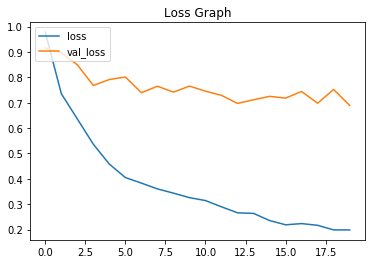

In [13]:
out_class_count = len(np.bincount(y))
# shifts = 28
epochs = 20
# xy_data = (x_train, y_train, x_test, y_test)

# x_train, y_train, x_test, y_test = xy_data

model = Sequential()
layer_0 = Dense(units =input_d//4, input_dim = input_d,
                kernel_initializer = "random_normal", activation = "relu")
model.add(layer_0)
model.add(Dropout(0.25))
layer_1 = Dense(units =shift1,kernel_initializer = "random_normal", activation = "relu")
model.add(layer_1)
model.add(Dropout(0.25))
layer_out = Dense(units = out_class_count,kernel_initializer = "random_normal", 
                  activation = "softmax")
model.add(layer_out)
#     model.summary()
model.compile(loss="categorical_crossentropy",optimizer = "adam", metrics = ['accuracy'])
train_history = model.fit(x = x_train, y = np_utils.to_categorical(y_train), batch_size=3,
                          validation_split = 0.2, epochs =epochs, verbose = 2)
plt.plot(train_history.history["loss"])
plt.plot(train_history.history["val_loss"])
plt.title("Loss Graph")
plt.legend(['loss', 'val_loss'], loc="upper left")

#     model_test
pre = model.predict_classes(x_test)
acc = round(accuracy_score(y_test, pre)*100,2)
print(acc)